https://www.kaggle.com/snap/amazon-fine-food-reviews

https://www.kaggle.com/rajmehra03/a-detailed-explanation-of-keras-embedding-layer
https://www.kaggle.com/gpayen/building-a-prediction-model/output

In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

## Milestone 1 

- Process model
- architectural decision
- use case identification
- data spurce identificaition
- Data exploration



The aim of my work is to design and implement a way to predict the sentiment of a given review and the predicted importance. This tool may answer the following questions:

- Is a review positive, and how relevant it is?
- Is the review written by an hater?
- Am I being bombed by fake negative review?

For this Project I'll use an LSTM model since it works well in many cases of sentiment analysis.



###  1. Data and usecase

As datasource for this project I've chosen the [Amazon Fine Food Reviews Dataset](https://www.kaggle.com/snap/amazon-fine-food-reviews) for sentiment analysis.


Here the description as reported from kaggle

![sdf](resources/kaggle_desc.png)

### 2. Data Exploration

Let's start by exploring our data

In [5]:
raw = pd.read_csv('data/reviews.csv')
raw[:5]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
raw.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [50]:
raw.shape

(568454, 10)

In [133]:
raw.dtypes

Id                         int64
ProductId                 object
UserId                    object
ProfileName               object
HelpfulnessNumerator       int64
HelpfulnessDenominator     int64
Score                      int64
Time                       int64
Summary                   object
Text                      object
dtype: object

#### 2.1. Deduplicate

In [105]:
raw[raw.columns.tolist()[1:]].drop_duplicates().shape, raw.shape

((568173, 9), (568454, 10))

Around 300 values are duplicates except for the id column. We will drop duplicates, since they don't bring any new information 

In [165]:
df = raw.drop_duplicates(subset=raw.columns.tolist()[1:])
df.shape

(568173, 10)

#### 2.1.1. Moreover I want to check duplicates for the couple product-user

In [166]:
tmp = df[:1000].groupby(['ProductId', 'UserId']).agg([list, len]).reset_index()
tmp.columns = tmp.columns.map('|'.join).str.strip('|')
tmp.sort_values('Id|len', ascending=False)[:5]

,ProductId,UserId,Id|list,Id|len,ProfileName|list,ProfileName|len,HelpfulnessNumerator|list,HelpfulnessNumerator|len,HelpfulnessDenominator|list,HelpfulnessDenominator|len,Score|list,Score|len,Time|list,Time|len,Summary|list,Summary|len,Text|list,Text|len
276,B000G6RYNE,A3PJZ8TU8FDQ1K,"[467, 468, 575, 603, 604]",5,"[Jared Castle, Jared Castle, Jared Castle, Jar...",5,"[0, 0, 2, 1, 1]",5,"[0, 0, 2, 1, 1]",5,"[5, 5, 5, 5, 5]",5,"[1231718400, 1231718400, 1231718400, 123707520...",5,"[One bite and you'll become a ""chippoisseur"", ...",5,"[I'm addicted to salty and tangy flavors, so w...",5
55,B000ER6YO0,A3NHUQ33CFH3VM,"[900, 901, 902, 904]",4,"[Citizen John, Citizen John, Citizen John, Cit...",4,"[8, 6, 5, 3]",4,"[8, 6, 5, 3]",4,"[3, 4, 3, 3]",4,"[1248912000, 1255651200, 1255651200, 1255651200]",4,[Our twins love this one. With the subscriptio...,4,[Both our twins love this one right from the s...,4
282,B000G6RYNE,A3RMGIKUWGPZOK,"[463, 541, 572, 601]",4,"[Jean Visnefski, Jean Visnefski, Jean Visnefsk...",4,"[0, 1, 2, 1]",4,"[0, 3, 2, 1]",4,"[5, 3, 5, 5]",4,"[1245024000, 1245024000, 1252108800, 1245024000]",4,"[One of Their Best Flavors, Not the Best, Grea...",4,[Kettle Chips flavors can be hit or miss. Som...,4
240,B000G6RYNE,A31N6KB160O508,"[472, 486, 487]",3,"[Fran W., Fran W., Fran W.]",3,"[0, 0, 0]",3,"[0, 0, 0]",3,"[4, 4, 4]",3,"[1219795200, 1214006400, 1214006400]",3,"[Pretty good tasting chip, Not bad but a littl...",3,[It took a while to get used to these chips bu...,3
224,B000G6RYNE,A2OEUROGZDTXUJ,"[432, 504, 588]",3,"[J. Graves, J. Graves, J. Graves]",3,"[0, 1, 1]",3,"[0, 2, 1]",3,"[5, 4, 5]",3,"[1327881600, 1327968000, 1327968000]",3,"[Delicious!, I like them., My favorite Kettle ...",3,"[Now, I haven't done a side-by-side comparison...",3


In [167]:
tmp.sort_values('Id|len', ascending=False)[:5]

,ProductId,UserId,Id|list,Id|len,ProfileName|list,ProfileName|len,HelpfulnessNumerator|list,HelpfulnessNumerator|len,HelpfulnessDenominator|list,HelpfulnessDenominator|len,Score|list,Score|len,Time|list,Time|len,Summary|list,Summary|len,Text|list,Text|len
276,B000G6RYNE,A3PJZ8TU8FDQ1K,"[467, 468, 575, 603, 604]",5,"[Jared Castle, Jared Castle, Jared Castle, Jar...",5,"[0, 0, 2, 1, 1]",5,"[0, 0, 2, 1, 1]",5,"[5, 5, 5, 5, 5]",5,"[1231718400, 1231718400, 1231718400, 123707520...",5,"[One bite and you'll become a ""chippoisseur"", ...",5,"[I'm addicted to salty and tangy flavors, so w...",5
55,B000ER6YO0,A3NHUQ33CFH3VM,"[900, 901, 902, 904]",4,"[Citizen John, Citizen John, Citizen John, Cit...",4,"[8, 6, 5, 3]",4,"[8, 6, 5, 3]",4,"[3, 4, 3, 3]",4,"[1248912000, 1255651200, 1255651200, 1255651200]",4,[Our twins love this one. With the subscriptio...,4,[Both our twins love this one right from the s...,4
282,B000G6RYNE,A3RMGIKUWGPZOK,"[463, 541, 572, 601]",4,"[Jean Visnefski, Jean Visnefski, Jean Visnefsk...",4,"[0, 1, 2, 1]",4,"[0, 3, 2, 1]",4,"[5, 3, 5, 5]",4,"[1245024000, 1245024000, 1252108800, 1245024000]",4,"[One of Their Best Flavors, Not the Best, Grea...",4,[Kettle Chips flavors can be hit or miss. Som...,4
240,B000G6RYNE,A31N6KB160O508,"[472, 486, 487]",3,"[Fran W., Fran W., Fran W.]",3,"[0, 0, 0]",3,"[0, 0, 0]",3,"[4, 4, 4]",3,"[1219795200, 1214006400, 1214006400]",3,"[Pretty good tasting chip, Not bad but a littl...",3,[It took a while to get used to these chips bu...,3
224,B000G6RYNE,A2OEUROGZDTXUJ,"[432, 504, 588]",3,"[J. Graves, J. Graves, J. Graves]",3,"[0, 1, 1]",3,"[0, 2, 1]",3,"[5, 4, 5]",3,"[1327881600, 1327968000, 1327968000]",3,"[Delicious!, I like them., My favorite Kettle ...",3,"[Now, I haven't done a side-by-side comparison...",3


I'll take the first of them to see what is going on

In [168]:
df[(df['ProductId']=='B000G6RYNE') & (df['UserId']=='A3PJZ8TU8FDQ1K')]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
466,467,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0,0,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
467,468,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,0,0,5,1231718400,"Crunchy, salty, sweet...finally, a Superbowl s...",These Honey Dijon chips bring a terrific balan...
574,575,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,2,2,5,1231718400,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."
602,603,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1237075200,"One bite and you'll become a ""chippoisseur""","As an Oregonian, I make a point of sharing the..."
603,604,B000G6RYNE,A3PJZ8TU8FDQ1K,Jared Castle,1,1,5,1229385600,"One bite and you'll become a ""chippoisseur""","I'm addicted to salty and tangy flavors, so wh..."


it is not very clear what happens, my assumption is that each row is generated each time there is a change in the review, let's take the last available date 

In [169]:
df = (df
       .sort_values(['Time', 'HelpfulnessNumerator', 'HelpfulnessDenominator'])
       .groupby(['UserId', 'ProductId'])
       .tail(1)
      )
df[:5]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


####  2.2. Missing values

In [170]:
df.isna().any()

Id                        False
ProductId                 False
UserId                    False
ProfileName                True
HelpfulnessNumerator      False
HelpfulnessDenominator    False
Score                     False
Time                      False
Summary                    True
Text                      False
dtype: bool

since we consider UserId, we don't care about null values in ProfileName. Instead we should check for null in summary

In [171]:
df.Summary.isna().sum()

27

ok we can drop them since they are quite few

In [172]:
df = df[-df.Summary.isna()]
df[:5]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150523,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150500,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...
451855,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...
230284,230285,B00004RYGX,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."
374358,374359,B00004CI84,A344SMIA5JECGM,Vincent P. Ross,1,2,5,944438400,A modern day fairy tale,"A twist of rumplestiskin captured on film, sta..."


#### 2.3. Distribution


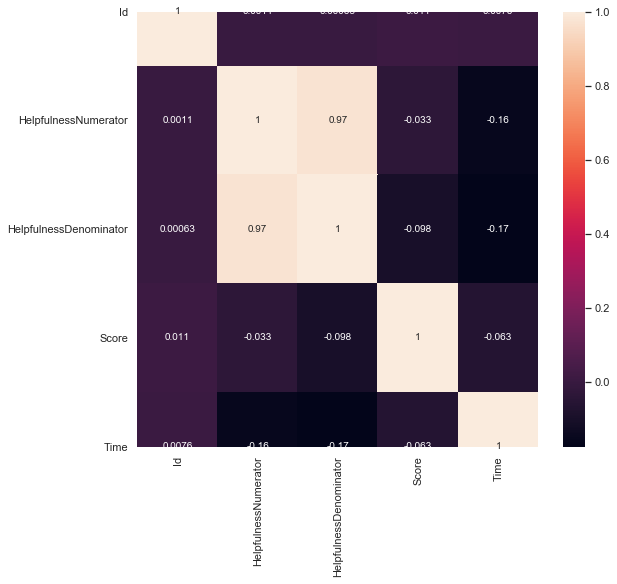

In [177]:
plt.rcParams["figure.figsize"] = (8,8)
sns.heatmap(df.corr(), annot=True)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.rcParams["figure.figsize"] = (8,5);

In [173]:
df.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,560777.000000,560777.000000,560777.000000,560777.000000,5.607770e+05
mean,284312.766417,1.738916,2.221566,4.182440,1.296597e+09
std,164099.339523,7.605249,8.240001,1.311068,4.792513e+07
min,1.000000,0.000000,0.000000,1.000000,9.393408e+08
25%,142240.000000,0.000000,0.000000,4.000000,1.271894e+09
50%,284314.000000,0.000000,1.000000,5.000000,1.311552e+09
75%,426474.000000,2.000000,2.000000,5.000000,1.332893e+09
max,568454.000000,866.000000,923.000000,5.000000,1.351210e+09


Let's show features distributions

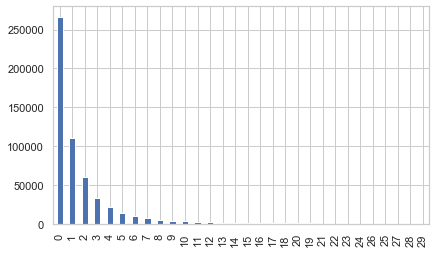

In [149]:
df['HelpfulnessDenominator'][lambda x: x<30].value_counts().plot.bar();

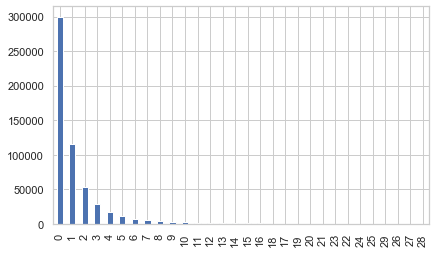

In [152]:
df['HelpfulnessNumerator'][lambda x: x<30].value_counts().plot.bar();

The distributions of HelpfulnessNumerator and HelpfulnessDenominator are right skewed, almost half of the samples have 0. If we subsample the data we should probably stratify to take less 0s since we will build the target variable partially from these columns

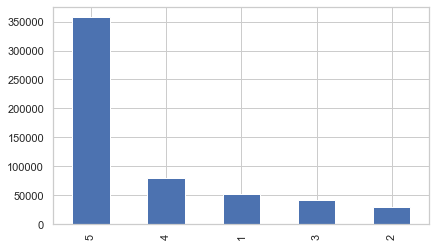

In [153]:
df['Score'].value_counts().plot.bar();

Also the score is umbalanced, with more than half samples given by the 5-starred reviews

In [180]:
pd.to_datetime(df['Time'], unit='s').describe()

count                  560777
unique                   3164
top       2012-10-16 00:00:00
freq                     1139
first     1999-10-08 00:00:00
last      2012-10-26 00:00:00
Name: Time, dtype: object

Finally we controlled the Time distribution to find out whether samples out of ranges are given. In this case no 

##  Milestone 2

### 3. Preprocessing and feature engineering

#### 3.1. Target variable
First we need to create the target feature. I want to predict whether the review is useful or not so we need a binary target. I define a helpfulness score which takes HelpfulnessNumerator and HelpfulnessDenominator between 0 and 1

In [181]:
df['helpfulness'] = np.minimum(1, df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1e-6))
df['helpfulness'][:5]

150523    0.0
150500    1.0
451855    0.0
230284    0.5
374358    0.5
Name: helpfulness, dtype: float64

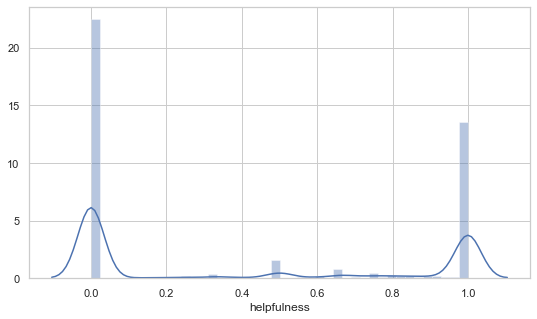

In [184]:
sns.distplot(df['helpfulness'])

In [215]:
HELPFULNESS_THS = .499
(df['helpfulness']<HELPFULNESS_THS).sum(), (df['helpfulness']>HELPFULNESS_THS).sum()

(315715, 245062)

Considering 0.5 seems a pretty balanced choice. I'll try with that and I'll build the target variable

In [216]:
df['target'] = df['helpfulness'] >= HELPFULNESS_THS
df['target'][:5]

150523    False
150500     True
451855    False
230284     True
374358     True
Name: target, dtype: bool

In [217]:
df['target'].value_counts()

False    315715
True     245062
Name: target, dtype: int64

In [219]:
df[df['target']>.5].sort_values('helpfulness')[:5]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfulness,target
482953,482954,B00206I9RS,A2FB16TK0NORBP,C.C.,1,2,5,1325203200,So much fun,Our daughter had a lot of fun making these coo...,0.5,True
201330,201331,B000GW46DE,A2OTO7TH9F433R,Fluffy,1,2,3,1233360000,Could stay a little fresher since vaccummed se...,"Even though these are in sealed, individual pa...",0.5,True
375781,375782,B006VRQLWM,A363CWAFMIG1A3,C. Maylett,1,2,1,1327449600,Yuck!,"I've been eating PowerBars for years, and thou...",0.5,True
359733,359734,B007M832YY,A350HRB16YUX9P,"R. Wismer ""Ron W""",1,2,3,1327449600,A little bland,I thought these were going to be sliced sweet ...,0.5,True
344650,344651,B0026KNQSA,A350HRB16YUX9P,"R. Wismer ""Ron W""",1,2,3,1327449600,A little bland,I thought these were going to be sliced sweet ...,0.5,True


At this point we can store the preprocessed data since in the next step we'll probably subsample the dataset

In [220]:
df.to_csv('./data/reviews_target.csv', index=False)

#### 3.2. NLP Preprocessing
In order to use text data, we need to apply some transformations, in this section we define a preprocessing pipeline to let us eventually tune the parameters. 

In [45]:
import sys, os, re, csv, codecs, datetime, numpy as np, pandas as pd

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [46]:
data = pd.read_csv('data/reviews_target.csv')[:50000]
data[:3]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,helpfulness,target
0,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,5,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,0.0,False
1,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,5,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,1.0,True
2,451856,B00004CXX9,AIUWLEQ1ADEG5,Elizabeth Medina,0,0,5,944092800,Entertainingl Funny!,Beetlejuice is a well written movie ..... ever...,0.0,False


In [47]:
y = pd.get_dummies(data['target'])
X = data['Text'].apply(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
list_sentences_train = X_train.fillna("_na_").values
y_t = y_train.values
list_sentences_test = X_test.fillna("_na_").values
y_te = y_test.values

In [49]:
embed_size = 50 # how big is each word vector
max_features = 20000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 347 # max number of words in a comment to use

In [50]:
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

### 4. Model definition and training

#### 4.1. Load Glove Embeddings

In [51]:
path = './models/'
EMBEDDING_FILE = f'{path}glove.6B.50d.txt'

In [52]:
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open(EMBEDDING_FILE, encoding='utf8'))

In [53]:
all_embs = np.stack(embeddings_index.values())
emb_mean, emb_std = all_embs.mean(), all_embs.std()
emb_mean, emb_std

C:\Users\g.gagliano\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


(0.020940498, 0.6441043)

In [54]:
word_index = tokenizer.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

#### 4.2. Build Model

In [55]:
inp = Input(shape=(maxlen,))
x = Embedding(max_features, embed_size, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(2, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [60]:
log_dir = ".\\logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
all_callbacks = [EarlyStopping(patience=2),
                 TensorBoard(log_dir=log_dir, histogram_freq=1)]
model.fit(X_t, y_t, batch_size=32, epochs=10, validation_split=0.1, callbacks=all_callbacks);

Train on 36000 samples, validate on 4000 samples
Epoch 1/10
36000/36000 [==============================] - 544s 15ms/sample - loss: 0.6079 - accuracy: 0.6816 - val_loss: 0.5772 - val_accuracy: 0.7080
Epoch 2/10
36000/36000 [==============================] - 488s 14ms/sample - loss: 0.5576 - accuracy: 0.7134 - val_loss: 0.5425 - val_accuracy: 0.7220
Epoch 3/10
36000/36000 [==============================] - 470s 13ms/sample - loss: 0.4798 - accuracy: 0.7687 - val_loss: 0.5166 - val_accuracy: 0.7542
Epoch 4/10
36000/36000 [==============================] - 497s 14ms/sample - loss: 0.4026 - accuracy: 0.8142 - val_loss: 0.5270 - val_accuracy: 0.7513
Epoch 5/10
36000/36000 [==============================] - 501s 14ms/sample - loss: 0.3422 - accuracy: 0.8470 - val_loss: 0.5504 - val_accuracy: 0.7570


### 5. Model evaluation

In [65]:
score, acc = model.evaluate(X_te, y_te, verbose = 2, batch_size = 32)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

10000/10000 - 23s - loss: 0.5497 - accuracy: 0.7548
score: 0.55
acc: 0.75


In [64]:
pos_cnt, neg_cnt, pos_correct, neg_correct = 0, 0, 0, 0
for x in range(len(X_te)):
    
    result = model.predict(X_te[x].reshape(1, X_te.shape[1]), batch_size=1, verbose = 2)[0]
   
    if np.argmax(result) == np.argmax(y_te[x]):
        if np.argmax(y_te[x]) == 0:
            neg_correct += 1
        else:
            pos_correct += 1
       
    if np.argmax(y_te[x]) == 0:
        neg_cnt += 1
    else:
        pos_cnt += 1

print("pos_acc", pos_correct/pos_cnt*100, "%")
print("neg_acc", neg_correct/neg_cnt*100, "%")

1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x000001C569D629D8>
Traceback (most recent call last):
  File "C:\Users\g.gagliano\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\data\ops\iterator_ops.py", line 537, in __del__
    handle=self._handle, deleter=self._deleter)
  File "C:\Users\g.gagliano\AppData\Local\Continuum\anaconda3\envs\tf2\lib\site-packages\tensorflow_core\python\ops\gen_dataset_ops.py", line 1139, in delete_iterator
    tld.op_callbacks, handle, deleter)
KeyboardInterrupt: 


1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s
1/1 - 0s


KeyboardInterrupt: 